In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize, signal, integrate

from scifit.solvers import FitSolver1D

from sklearn import metrics
from sklearn.linear_model import LinearRegression

Checks:

 - https://www.wolframalpha.com/input?i=solve+%7Bc1+%3D+1%2F%28k1*V%29*%281-k2%29%3B+c2+%3D+-+1%2F%28k1*V%29*k2*n0%7D+for+%7Bk1%2C+k2%7D
 - https://www.wolframalpha.com/input?i=integral+b*x%2F%28a*%28n0-x%29%29


In [2]:
np.random.seed(12345)

In [3]:
R = 8.31446261815324  # J/mol.K
T0 = 292.05           # K
p0 = 101600           # Pa
V = 190e-3            # L of isopropanol

In [4]:
rho = 785             # g/L
M = 60.1              # g/mol
A0 = rho/M*V           # mol

In [5]:
A0

2.4816971713810316

In [6]:
k = 8.765e-6          # mol/s
b = 9.876e5
a = 1.234e4

In [7]:
b/a

80.03241491085899

In [8]:
def model(x, k, a, b, A0=A0):
    return k*(a*(A0 - x))/(1 + a*(A0 - x) + b*x)

In [9]:
def ode(t, x, k, a, b, A0):
    return np.array([
        model(x, k, a, b, A0)
    ])

In [10]:
t = np.linspace(0, 10000, 101)

In [11]:
sol = integrate.solve_ivp(ode, [t.min(), t.max()], y0=[0], args=(k, a, b, A0), t_eval=t)

In [12]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e+02 ...  9.900e+03  1.000e+04]
        y: [[ 0.000e+00  8.644e-04 ...  4.844e-02  4.877e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 62
     njev: 0
      nlu: 0

In [13]:
xi = sol.y[0,:]

In [14]:
r = ode(t, xi, k, a, b, A0).squeeze()

In [15]:
sigma = 15

In [16]:
tn = (t + sigma*np.random.normal(size=t.size)).round(1)

In [17]:
Vc = xi*R*T0/p0

In [18]:
data = pd.DataFrame({"t": t, "tn": tn, "V": Vc, "xi": xi, "r": r})

In [19]:
data["rinv"] = 1/data["r"]
data["x1"] = data["xi"]/(A0 - data["xi"])
data["x2"] = np.log((A0 - data["xi"])/A0)

In [20]:
data["dxidt"] = data["xi"].diff()/data["tn"].diff()

In [21]:
coefs = np.polyfit(data["tn"], xi, 3)
data["xiP3"] = np.polyval(coefs, data["tn"])
data["rP3"] = np.polyval(np.polyder(coefs, m=1), data["tn"])

In [22]:
data["xiSG"] = signal.savgol_filter(data["xi"], 7, 3)
data["rSG"] = signal.savgol_filter(data["xi"], 7, 3, deriv=1, delta=np.diff(t)[0])

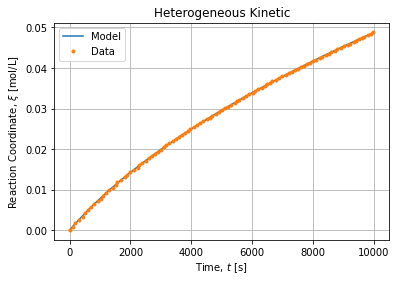

In [23]:
fig, axe = plt.subplots()
axe.plot(data["t"], data["xi"], label="Model")
axe.plot(data["tn"], data["xi"], linestyle="None", marker=".", label="Data")
#axe.plot(data["tn"], data["xiP3"])
#axe.plot(data["tn"], data["xiSG"])
axe.set_title("Heterogeneous Kinetic")
axe.set_xlabel(r"Time, $t$ [s]")
axe.set_ylabel(r"Reaction Coordinate, $\xi$ [mol/L]")
axe.legend()
axe.grid()

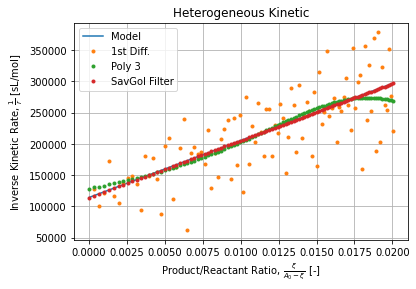

In [24]:
fig, axe = plt.subplots()
axe.plot(data["x1"], data["rinv"], label="Model")
axe.plot(data["x1"], 1/data["dxidt"], linestyle="None", marker=".", label="1st Diff.")
axe.plot(data["x1"], 1/data["rP3"], linestyle="None", marker=".", label="Poly 3")
axe.plot(data["x1"], 1/data["rSG"], linestyle="None", marker=".", label="SavGol Filter")
axe.set_title("Heterogeneous Kinetic")
axe.set_xlabel(r"Product/Reactant Ratio, $\frac{\xi}{A_0 - \xi}$ [-]")
axe.set_ylabel(r"Inverse Kinetic Rate, $\frac{1}{r}$ [sL/mol]")
axe.legend()
axe.grid()

In [25]:
regressor = LinearRegression(fit_intercept=False)

In [26]:
regressor.fit(data[["xi", "x2"]].values, data["tn"].values)

LinearRegression(fit_intercept=False)

In [27]:
c1, c2 = regressor.coef_
c1, c2

(-9056553.320956195, -22758064.368196405)

In [28]:
s = regressor.score(data[["xi", "x2"]].values, data["tn"])

In [29]:
k1 = A0/((A0*c1 - c2))
k2 = -c2/(A0*c1 - c2)

In [30]:
k1, k2

(8.786584877247457e-06, 80.57617444989894)

In [31]:
OLS = {"k1": k1, "k2": k2, "R2": s, "name": "OLS"}

In [32]:
def naive(x, k1, k2):
    return (1/k1) * ((1 - k2)*x - k2*A0*np.log((A0 - x)/A0)) 

In [33]:
popt, pcov = optimize.curve_fit(naive, data["xi"].values, data["tn"].values)

In [34]:
s2 = metrics.r2_score(data["tn"].values, naive(data["xi"].values, *popt))

In [35]:
NLLS = {"k1": popt[0], "k2": popt[1], "R2": s2, "name": "NLLS"}

In [36]:
def LB(X, y, name):
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    s = model.score(X, y)
    c1 = model.intercept_
    c2 = model.coef_[0]
    k1 = 1/c1
    k2 = c2/c1
    return {
        "k1": k1,
        "k2": k2,
        "R2": s,
        "name": name
    }

In [37]:
lb_th = LB(data[["x1"]].values, data["rinv"].values, name="LB Exact")
lb_th

{'k1': 8.764713797255641e-06,
 'k2': 80.02983427263413,
 'R2': 1.0,
 'name': 'LB Exact'}

In [38]:
lb_dxi = LB(data.loc[1:,["x1"]].values, (1/data.loc[1:,"dxidt"]).values, name="LB First Diff.")
lb_dxi

{'k1': 8.74018793561218e-06,
 'k2': 78.3778701765218,
 'R2': 0.5453385467067531,
 'name': 'LB First Diff.'}

In [39]:
lb_P3 = LB(data[["x1"]].values, (1/data["rP3"]).values, name="LB Poly 3")
lb_P3

{'k1': 8.334781616000142e-06,
 'k2': 71.09313406468245,
 'R2': 0.9796475896983575,
 'name': 'LB Poly 3'}

In [40]:
lb_SG = LB(data[["x1"]].values, (1/data["rSG"]).values, name="LB SavGol")
lb_SG

{'k1': 8.763848321536997e-06,
 'k2': 80.03190798581407,
 'R2': 0.9999936911896604,
 'name': 'LB SavGol'}

In [41]:
results = pd.DataFrame([OLS, NLLS, lb_th, lb_dxi, lb_P3, lb_SG])
results

,k1,k2,R2,name
0,0.000009,80.576174,0.999972,OLS
1,0.000009,80.576176,0.999972,NLLS
2,0.000009,80.029834,1.000000,LB Exact
3,0.000009,78.377870,0.545339,LB First Diff.
4,0.000008,71.093134,0.979648,LB Poly 3
5,0.000009,80.031908,0.999994,LB SavGol


In [42]:
class Model(FitSolver1D):
    @staticmethod
    def model(x, k1, k2):
        return (1/k1) * ((1 - k2)*x[:,0] - k2*A0*np.log((A0 - x[:,0])/A0)) 

In [43]:
model = Model()
sol = model.fit(data[["xi"]].values, data["tn"].values, sigma=sigma)

Text(0, 0.5, 'Time, $t$ [s]')

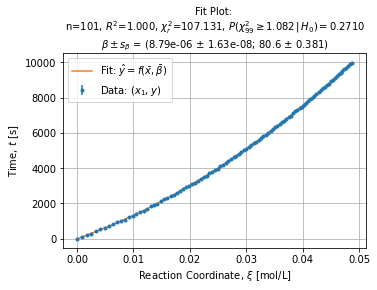

In [44]:
axe = model.plot_fit()
axe.set_xlabel(r"Reaction Coordinate, $\xi$ [mol/L]")
axe.set_ylabel(r"Time, $t$ [s]")

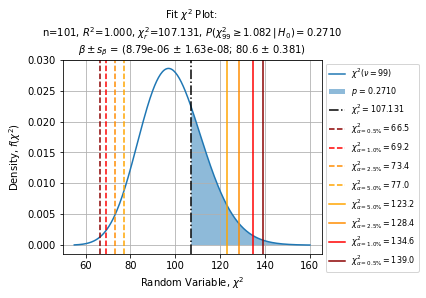

In [45]:
axe = model.plot_chi_square()

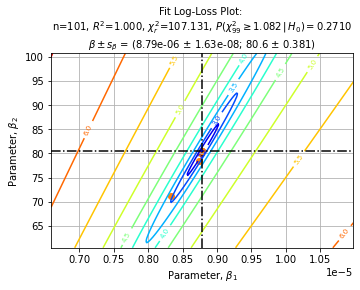

In [46]:
axe = model.plot_loss(factor=2.5, log_loss=True, log_x=False, log_y=False, resolution=200)
axe.scatter(results["k1"], results["k2"])
#axe.grid(which="both")

In [47]:
data[["t", "V"]].to_csv("data/cathet2.csv", index=False)